# ISLR-Python: Applied 11

- [Load Boston Dataset](#Load-Boston-Dataset)
- [Scatterplot Data](#Scatterplot-Data)
- [Full Least Squares Model](#Full-Least-Squares-Model)
- [Ridge Regression Model](#Ridge-Regression-Model)
- [Lasso Regression Model](#Lasso-Regression-Model)
- [Comments on Models](#Comments-on-Models)

In [87]:
import numpy as np
import pandas as pd

from operator import itemgetter

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Boston Dataset

In [4]:
# Load the boston data set. We will try to predict per capita crime rate
boston = pd.read_csv('../../../data/Boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Scatterplot Data

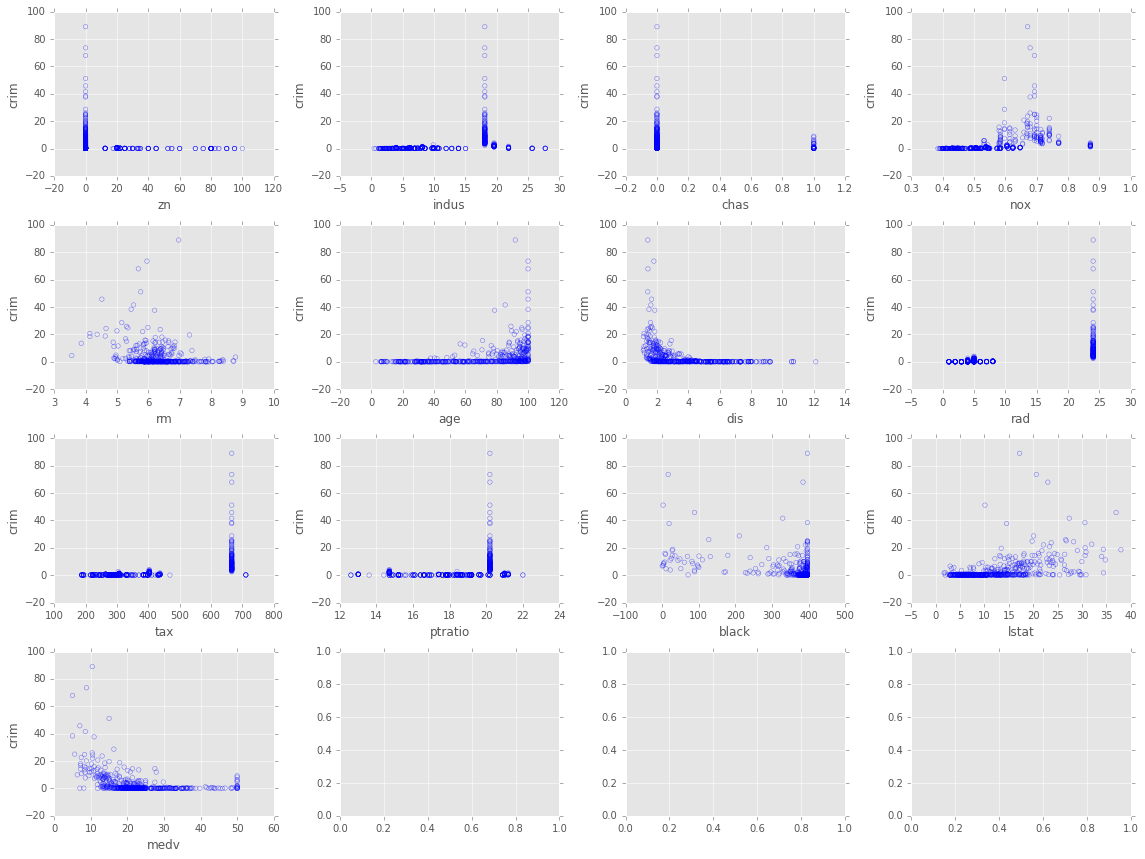

In [26]:
# Define predictor and response variables
predictors = list(boston.columns[1:])
crime = boston.crim

# A really good idea is to start with some plots to get a feel for how the predictors relate to the response
fig, axarr = plt.subplots(4,4,figsize=(16,12))

for p, predictor in enumerate(predictors):
    index = np.unravel_index(p,(4,4))
    axarr[index[0], index[1]].scatter(boston[predictor],boston.crim, facecolors='none', edgecolors='b', alpha=0.5)
    axarr[index[0], index[1]].set_xlabel(predictor)
    axarr[index[0], index[1]].set_ylabel('crim')
    
plt.tight_layout()

From the scatter plots here, we would guess that the following predictors may be useful in predicting crime rate: zn, indus, nox,rm, age, dis, rad, ptratio, lstat and medv. A description of each of these predictors is here:
https://archive.ics.uci.edu/ml/datasets/Housing

## Full Least Squares Model

We first want to get an idea of the test error rate using all of the features. This will give us a bechmark to comppare our regularization models with. Since the data set is small, we will employ cross-validation to get an estimate of the test MSE.

In [79]:
np.random.seed(0)
ls_model = LinearRegression()
ls_mse = -np.mean(cross_val_score(ls_model, boston[predictors], boston.crim,
                                  scoring='mean_squared_error', cv=len(boston)))

print('LOOCV Estimate of Least Squares Test MSE = ', ls_mse)

LOOCV Estimate of Least Squares Test MSE =  42.9687402159


## Ridge Regression Model

Now that we know how the full least squares model performs, we can try out some of the regularization and dimension reduction methods we have seen in this chapter. Lets take a look at Ridge Regression...

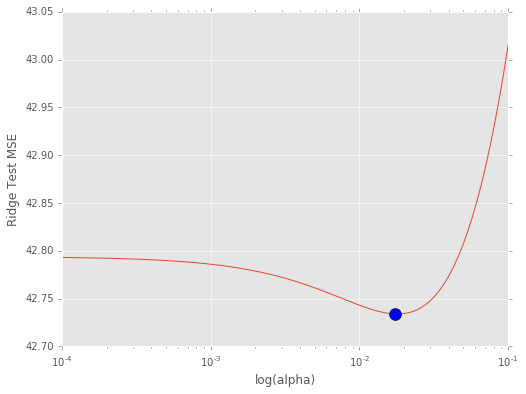

Ridge Regression LOOCV Test MSE Estimate =  42.7340030152 

Intercept    13.888385
zn            0.040021
indus        -0.077533
chas         -0.732037
nox          -8.457866
rm            0.401456
age           0.001326
dis          -0.883139
rad           0.519440
tax          -0.000527
ptratio      -0.220479
black        -0.007915
lstat         0.135332
medv         -0.175396
dtype: float64


In [72]:
# Remeber for ridge we need to scale the predictors so that predictors measured on different scales are
# penalized equivalently. We will pass normalize option to ridgeCV

# create a set array of regularization hyperparameters
lambdas = 10**np.linspace(-4,-1, 100)
ridge = RidgeCV(alphas=lambdas, fit_intercept=True, normalize=True, store_cv_values=True)
ridge.fit(boston[predictors],boston.crim)

# Get the alpha with the minimum cv test error
ridge_mse = np.mean(ridge.cv_values_, axis=0)
min_mse_idx, min_ridge_mse = min(enumerate(ridge_mse), key=itemgetter(1))

# Plot the ridge's test mse
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(lambdas, ridge_mse)
ax1.plot(lambdas[min_mse_idx], min_ridge_mse, marker='o', color='b', markersize=12);
ax1.set_xscale('log');
ax1.set_xlabel('log(alpha)');
ax1.set_ylabel('Ridge Test MSE');
plt.show()

# Print the Ridge's Test MSE at the optimal alpha
print('Ridge Regression LOOCV Test MSE Estimate = ', min_ridge_mse,'\n')

# Print the Ridge Regression Coeffecients
print(pd.Series(data = np.hstack([ridge.intercept_,ridge.coef_]), index=['Intercept'] + predictors))

## Lasso Regression Model

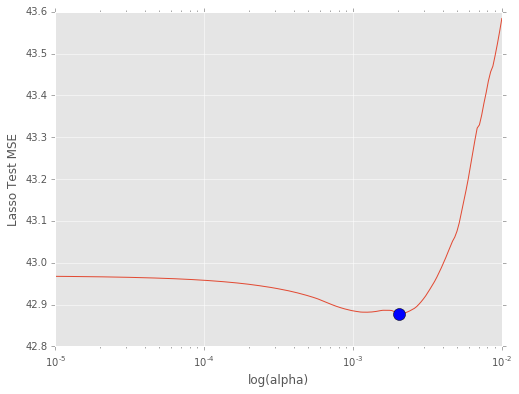

Lasso Regression LOOCV Test MSE Estimate =  42.8774674956 

Intercept    13.081109
zn            0.036891
indus        -0.072648
chas         -0.593485
nox          -7.355077
rm            0.252711
age           0.000000
dis          -0.810952
rad           0.516653
tax          -0.000000
ptratio      -0.197688
black        -0.007546
lstat         0.125525
medv         -0.161972
dtype: float64


In [84]:
# Fit a lasso model with 100 alpha values and LOOCV. Be sure to normalize
lambdas = 10**np.linspace(-5,-2, 200)
lasso = LassoCV(alphas=lambdas, fit_intercept=True, normalize=True, cv=len(boston))
lasso.fit(boston[predictors],boston.crim)

lasso_mse = np.mean(lasso.mse_path_, axis=1)
min_lasso_mse = min(lasso_mse)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lasso.alphas_, lasso_mse )
ax.plot(lasso.alpha_, min_lasso_mse, marker='o', color='b', markersize=12);
ax.set_xscale('log');
ax.set_xlabel('log(alpha)');
ax.set_ylabel('Lasso Test MSE');
plt.show()

print('Lasso Regression LOOCV Test MSE Estimate = ', min(lasso_mse),'\n')
# Print the Lasso Regression Coeffecients
print(pd.Series(data = np.hstack([lasso.intercept_, lasso.coef_]), index=['Intercept'] + predictors))

Both the Ridge and Lasso models make very little improvement to the linear model. We can take a look at the residuals. If there are strong patterns in the residuals then this indicates non-linearity in the data that is not being captured by the model. Non-linearity can make regularization attempts useless.

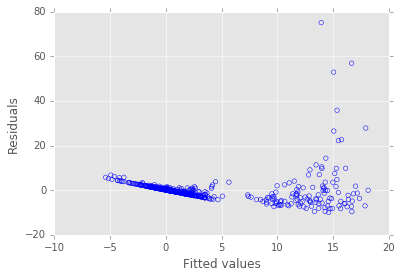

In [89]:
# use stats models to make a new linear model since it provides many inferential outputs
lm = sm.OLS(boston.crim, sm.add_constant(boston[predictors]))
results = lm.fit()

# Plot residuals to inspect data for nonlinearity
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(results.fittedvalues.values, results.resid.values, facecolors='none', edgecolors='b');
ax.set_xlabel('Fitted values');
ax.set_ylabel('Residuals');

## Comments on Models

The residuals have a clear **U-shape indicating Nonlinear relationships** between the predictors and the crim rate response variable. A second feature is that the residuals increase with increasing fitted values. This **funnel shape indicates Heteroscedasticity **, indicating non-constant variance of the error terms. This violates assumptions of the least squares model fit. A third feature is **the large residuals at some fitted values indicate Outliers ** around fitted values of 15-18. All of these aspects of the data cast suspicision on the fit of the linear model. We would not expect regularization to improve a linear model when the underlying data exhibits these features. Thus the best linear model is a model with all the features.